In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
X = np.load('x_letters.npy')
Y = np.load('y_letters.npy')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])

In [3]:
def build_discriminator(img_dim, num_classes):
    # image input 28x28x1 for grayscale images
    image_input= layers.Input(shape=(img_dim, img_dim,1))
    n_nodes = img_dim * img_dim
    # embedding the label input
    in_label = layers.Input(shape=(1,))
    label_input = layers.Embedding(num_classes, 10)(in_label)
    label_input = layers.Dense(n_nodes)(label_input)
    label_input = layers.Reshape((img_dim, img_dim, 1))(label_input)

    concat= layers.Concatenate()([image_input, label_input])
    concat = layers.GaussianNoise(0.1)(concat)
    fe = layers.Conv2D(4, (14,14), strides=(2,2), padding='same')(concat)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    fe = layers.Flatten()(fe)
    fe = layers.Dropout(0.6)(fe)

    real_or_fake= layers.Dense(1, activation='sigmoid')(fe)

    return tf.keras.Model([image_input, in_label], real_or_fake)

In [4]:

def build_generator(img_dim, num_classes, latent_dim):
    # label input
    in_label = layers.Input(shape=(1,))
    # embedding for categorical input
    li = layers.Embedding(num_classes, 10)(in_label)

    # Flatten the embedding output
    li = layers.Flatten()(li)
    # linear multiplication
    n_nodes = 7 * 7
    li = layers.Dense(n_nodes)(li)

    # reshape to additional channel
    li = layers.Reshape((7, 7, 1))(li)

    # Fully connected layers
    in_latent = layers.Input(shape=(latent_dim,))

    latent_input = layers.Dense(128*7*7, activation="relu", kernel_initializer="he_normal")(in_latent)
    latent_input = layers.LeakyReLU(negative_slope=0.2)(latent_input)  # LeakyReLU is often used in GANs
    latent_input = layers.Reshape((7, 7, 128))(latent_input)  # Reshape for Conv2DTranspose

    # Concatenate latent and label inputs
    concat = layers.Concatenate()([latent_input, li])

   # Transposed convolutional layers to upscale the image
    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(concat)  # 7x7 -> 14x14
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)  # 14x14 -> 28x28
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Final layer to produce the output image
    generated_image = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='tanh')(x)  # 28x28x1

    return tf.keras.Model([in_latent, in_label], generated_image)



In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_labels = data  # Unpack the data (images and their labels)

        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # 1. Train the Discriminator:
        # --------------------------------


        # Generate random labels for the generated images
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        # Generate fake images conditioned on these random labels
        generated_images = self.generator([random_latent_vectors, random_labels])

        # Combine real and fake images and their labels
        combined_images = tf.concat([real_images, generated_images], axis=0)
        combined_labels = tf.concat([real_labels, random_labels], axis=0)

        real_fake_labels = tf.concat(
            [tf.ones((batch_size, 1)) * 0.9,  # Real labels smoothed (0.9 instead of 1)
            tf.zeros((batch_size, 1)) + 0.1 ],  # Fake labels smoothed (0.1 instead of 0)
            axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(real_fake_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # 2. Train the Generator:
        # --------------------------------
        # Sample random points in the latent space again
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Generate random labels again
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        # Assemble labels that say "all real images" (i.e., we want the generator to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) * 0.9

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, random_labels])
            predictions = self.discriminator([fake_images, random_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [6]:
def generate_and_compare_image(generator, latent_dim, label):
    # Step 1: Display the actual image from the dataset
    plt.figure(figsize=(3, 1))
    plt.subplot(1, 2, 1)
    plt.imshow(X[np.where(Y == label)[0][0]], cmap='gray', interpolation='nearest')
    plt.title("Real")
    plt.axis('off')  # Hide the axes

    # Step 2: Generate a random latent vector (noise)
    random_latent_vector = np.random.normal(size=(1, latent_dim))

    # Step 3: Pass the numeric label directly (no need for one-hot encoding)
    random_label = np.array([label], dtype=np.int32)  # Assuming labels are float32 like in the train_step

    # Step 4: Generate an image using the generator model
    generated_image = generator([random_latent_vector, random_label])
    # Step 5: Post-process the image (Rescale from [-1, 1] to [0, 1] for visualization)
    generated_image = (generated_image[0, :, :, 0] + 1) / 2.0  # Assuming it's grayscale

    # Step 6: Display the generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image, cmap='gray')
    plt.title("Generated")
    plt.axis('off')  # Turn off axis labels

    # Step 7: Show the comparison of actual vs generated images side by side
    plt.show()


In [7]:
def build_generator(img_dim, num_classes, latent_dim):
    # label input
    in_label = layers.Input(shape=(1,))
    # embedding for categorical input
    li = layers.Embedding(num_classes, 12)(in_label)  # Increased embedding size

    # Linear multiplication
    n_nodes = 7 * 7
    li = layers.Dense(n_nodes)(li)

    li = layers.Reshape((7, 7, 1))(li)
    # Fully connected layers
    in_latent = layers.Input(shape=(latent_dim,))

    latent_input = layers.Dense(128*7*7, activation="relu", kernel_initializer="he_normal")(in_latent)
    latent_input = layers.ReLU()(latent_input)  # LeakyReLU is often used in GANs
    latent_input = layers.Reshape((7, 7, 128))(latent_input)  # Reshape for Conv2DTranspose

    # Concatenate latent and label inputs
    concat = layers.Concatenate()([latent_input, li])

    # Transposed convolutional layers to upscale the image
    x = layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = "same", activation = "relu")(concat), #strides = 2 -> 14*14 maps - 64 of them
    x = layers.BatchNormalization()(x)  # Added BatchNorm for stability
    x = layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding = "same", activation = "tanh")(x)  # 14x14 -> 28x28

    # Final layer to produce the output image
    generated_image = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='tanh')(x)  # 28x28x1

    return tf.keras.Model([in_latent, in_label], generated_image)

def build_discriminator(img_dim, num_classes):
    # image input 28x28x1 for grayscale images
    image_input = layers.Input(shape=(img_dim, img_dim, 1))

    # embedding the label input
    n_nodes = img_dim * img_dim
    in_label = layers.Input(shape=(1,))
    label_input = layers.Embedding(num_classes, 5)(in_label)
    label_input = layers.Dense(n_nodes)(label_input)
    label_input = layers.Reshape((img_dim, img_dim, 1))(label_input)

    # Concatenate image and label input
    concat = layers.Concatenate()([image_input, label_input])

    fe = layers.Flatten()(concat)

    fe = layers.Dense(16)(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    fe = layers.Dropout(0.3)(fe)

    # Output
    real_or_fake = layers.Dense(1, activation='sigmoid')(fe)

    return tf.keras.Model([image_input, in_label], real_or_fake)



C:\Users\fisch\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 92s 40ms/step - d_loss: 1.2789 - g_loss: 0.3322
Epoch 2/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 90s 40ms/step - d_loss: 1.4051 - g_loss: 0.3282
Epoch 3/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - d_loss: 1.5835 - g_loss: 0.3309
Epoch 4/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 96s 43ms/step - d_loss: 1.3470 - g_loss: 0.5161
Epoch 5/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - d_loss: 1.4305 - g_loss: 0.3942


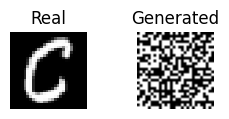

In [8]:
# Instantiate GAN model
img_dim = 28
num_classes = 26
latent_dim = 50

dis = build_discriminator(img_dim=img_dim, num_classes= num_classes)
gen = build_generator(img_dim=img_dim, num_classes=num_classes, latent_dim=latent_dim)

gan = GAN(discriminator=dis, generator=gen, latent_dim=latent_dim, num_classes=num_classes)

# Compile the GAN model
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Train the model
epochs = 5
# gen.summary(), dis.summary()
gan.fit(X_train, Y_train.astype('int32'), epochs=epochs)
generate_and_compare_image(gan.generator, latent_dim=latent_dim, label=2)


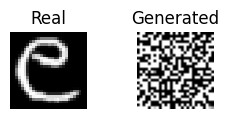

In [9]:
generate_and_compare_image(gan.generator, latent_dim=latent_dim, label=4)


In [10]:
gan.discriminator.predict([X_test, Y_test]).min()

555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.15839495

In [11]:
# Step 2: Generate a random latent vector (noise)
random_latent_vector = np.random.normal(size=(1, latent_dim))

# Step 3: Pass the numeric label directly (no need for one-hot encoding)
random_label = np.array([1], dtype=np.int32)  # Assuming labels are float32 like in the train_step

# Step 4: Generate an image using the generator model
generated_image = gan.generator([random_latent_vector, random_label])

gan.discriminator.predict([generated_image, random_label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


array([[0.85294074]], dtype=float32)